In [29]:
import os
import pickle
import pandas as pd
import zipfile

# Path to raw data
raw_data_path = "data/raw/"

# 1. Load Adjacency Matrix (adj_mx_bay.pkl)
with open(os.path.join(raw_data_path, 'adj_mx_bay.pkl'), 'rb') as f:
    adj_matrix = pickle.load(f, encoding='latin1')  # Road network relationships

# 2. Load Traffic Data (pems-bay.h5)
traffic_data = pd.read_hdf(os.path.join(raw_data_path, 'pems-bay.h5'))  # Time series sensor readings

# 3. Load Metadata (pems-bay-meta.h5)
metadata = pd.read_hdf(os.path.join(raw_data_path, 'pems-bay-meta.h5'))  # Sensor locations and attributes


In [ ]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler

def inspect_data(name, data, n=5):
    """Helper function to print data samples with smart formatting"""
    print(f"\n=== {name} ===")
    
    if isinstance(data, pd.DataFrame):
        print(f"Shape: {data.shape}")
        print(data.head(n))
    elif isinstance(data, np.ndarray):
        print(f"Shape: {data.shape}")
        if data.ndim == 1:
            print(data[:n])
        else:
            # For 2D arrays, show nxn submatrix
            print(data[:min(n, data.shape[0]), :min(n, data.shape[1])])
    elif hasattr(data, '__len__'):
        print(f"Length: {len(data)}")
        print(data[:n])
    else:
        print(data)

def process_traffic_data(traffic_data, metadata):
    """Robust processing pipeline with error handling"""
    
    # 1. Inspect input data
    inspect_data("Raw Traffic Data", traffic_data)
    inspect_data("Metadata", metadata)
    
    # 2. Linear interpolation
    print("\n1/4 Applying linear interpolation...")
    traffic_clean = traffic_data.interpolate(method='linear', axis=0, limit_direction='both')
    inspect_data("After Interpolation", traffic_clean)
    
    # 3. Min-Max normalization
    print("\n2/4 Normalizing data...")
    scaler = MinMaxScaler()
    traffic_normalized = pd.DataFrame(
        scaler.fit_transform(traffic_clean),
        columns=traffic_clean.columns,
        index=traffic_clean.index
    )
    inspect_data("After Normalization", traffic_normalized)
    
    # 4. Handle adjacency matrix creation
    print("\n3/4 Creating adjacency matrix...")
    adj_matrix = None
    
    # Check for alternative location column names
    loc_cols = []
    for potential in ['latitude', 'lat', 'Latitude', 'LAT']:
        if potential in metadata.columns:
            loc_cols.append(potential)
            break
            
    for potential in ['longitude', 'lon', 'Longitude', 'LON']:
        if potential in metadata.columns and len(loc_cols) < 2:
            loc_cols.append(potential)
    
    if len(loc_cols) == 2:
        print(f"Using location columns: {loc_cols}")
        sensor_locs = metadata[loc_cols].values
        dist_matrix = cdist(sensor_locs, sensor_locs, metric='euclidean')
        sigma = 0.1
        adj_matrix = np.exp(-dist_matrix ** 2 / sigma ** 2)
        np.fill_diagonal(adj_matrix, 1)
    else:
        print("No location data - using identity matrix as fallback")
        n_sensors = len(traffic_data.columns)
        adj_matrix = np.eye(n_sensors)
    
    inspect_data("Adjacency Matrix", adj_matrix)
    
    # 5. Temporal split
    print("\n4/4 Splitting data...")
    n_samples = len(traffic_normalized)
    splits = {
        'train': traffic_normalized.iloc[:int(n_samples*0.7)],
        'val': traffic_normalized.iloc[int(n_samples*0.7):int(n_samples*0.85)],
        'test': traffic_normalized.iloc[int(n_samples*0.85):]
    }
    
    for name, data in splits.items():
        inspect_data(f"{name.capitalize()} Set", data)
    
    return {**splits, 'adj_matrix': adj_matrix, 'scaler': scaler}

In [38]:
# Load your data first
traffic_data = pd.read_hdf("data/raw/pems-bay.h5")
metadata = pd.read_hdf("data/raw/pems-bay-meta.h5")

# Process the data
processed = process_traffic_data(traffic_data, metadata)

# Save results
output_dir = "data/processed/"
os.makedirs(output_dir, exist_ok=True)
np.save(os.path.join(output_dir, "adj_matrix.npy"), processed['adj_matrix'])
processed['train'].to_csv(os.path.join(output_dir, "train.csv"))
processed['val'].to_csv(os.path.join(output_dir, "val.csv"))
processed['test'].to_csv(os.path.join(output_dir, "test.csv"))


=== Raw Traffic Data ===
Shape: (52116, 325)
sensor_id            400001  400017  400030  400040  400045  400052  400057  \
2017-01-01 00:00:00    71.4    67.8    70.5    67.4    68.8    66.6    66.8   
2017-01-01 00:05:00    71.6    67.5    70.6    67.5    68.7    66.6    66.8   
2017-01-01 00:10:00    71.6    67.6    70.2    67.4    68.7    66.1    66.8   
2017-01-01 00:15:00    71.1    67.5    70.3    68.0    68.5    66.7    66.6   
2017-01-01 00:20:00    71.7    67.8    70.2    68.1    68.4    66.9    66.1   

sensor_id            400059  400065  400069  ...  409525  409526  409528  \
2017-01-01 00:00:00    68.0    66.8    69.0  ...    68.8    67.9    68.8   
2017-01-01 00:05:00    67.8    66.5    68.2  ...    68.4    67.3    68.4   
2017-01-01 00:10:00    67.8    66.2    67.8  ...    68.4    67.4    68.4   
2017-01-01 00:15:00    67.7    65.9    67.8  ...    68.5    67.5    68.5   
2017-01-01 00:20:00    67.7    66.1    67.8  ...    68.5    67.7    68.5   

sensor_id            4

In [50]:
def check_and_handle_nulls(data, plot=True):
    """
    Robust null checking with edge case handling
    Returns cleaned data (unchanged if no nulls) and null report
    """
    # 1. Null Value Analysis
    null_report = pd.DataFrame({
        'Null Count': data.isnull().sum(),
        'Null Percentage': data.isnull().mean() * 100
    }).sort_values('Null Count', ascending=False)
    
    print("=== Null Value Report ===")
    print(null_report)
    
    total_nulls = data.isnull().sum().sum()
    print(f"\nTotal null values in dataset: {total_nulls}")
    print(f"Percentage of null values: {total_nulls/np.prod(data.shape)*100:.2f}%")
    
    # 2. Visualization (only if nulls exist)
    if plot and total_nulls > 0:
        plt.figure(figsize=(12, 6))
        
        # Heatmap of null values
        plt.subplot(211)
        plt.imshow(data.isnull().T, aspect='auto', cmap='viridis', 
                  interpolation='nearest')
        plt.title('Null Values Heatmap')
        plt.xlabel('Time Index')
        plt.ylabel('Sensors')
        
        # Null distribution per sensor
        plt.subplot(212)
        null_report[null_report['Null Count'] > 0]['Null Count'].plot(kind='bar')
        plt.title('Null Counts by Sensor')
        plt.tight_layout()
        plt.show()
    elif plot:
        print("\nNo null values to visualize")
    
    # 3. Return unchanged data if no nulls
    if total_nulls == 0:
        print("\nData is clean - no null handling needed")
        return data.copy(), null_report
    
    # 4. Handle nulls if they exist (your original logic here)

    cleaned_data = data.copy()
    
    if total_nulls > 0:
        print("\n=== Handling Null Values ===")
        
        # For small gaps: linear interpolation
        if (null_report['Null Percentage'] < 5).all():
            print("Using linear interpolation for small gaps (<5% nulls)")
            cleaned_data = data.interpolate(method='linear', limit_area='inside')
            
        # For larger gaps: seasonal decomposition + interpolation
        elif (null_report['Null Percentage'] < 20).all():
            print("Using seasonal spline interpolation for moderate gaps (5-20% nulls)")
            cleaned_data = data.interpolate(method='spline', order=3, 
                                          limit_area='inside')
            
        # For sensors with excessive nulls (>20%)
        high_null_sensors = null_report[null_report['Null Percentage'] > 20].index
        if len(high_null_sensors) > 0:
            print(f"Dropping {len(high_null_sensors)} sensors with >20% nulls")
            cleaned_data = cleaned_data.drop(columns=high_null_sensors)
            
        # Forward/backward fill any remaining nulls
        remaining_nulls = cleaned_data.isnull().sum().sum()
        if remaining_nulls > 0:
            print(f"Filling {remaining_nulls} remaining nulls with last valid observation")
            cleaned_data = cleaned_data.ffill().bfill()
    
    # Final verification
    assert cleaned_data.isnull().sum().sum() == 0, "Null values still exist!"
    print("\n=== Null handling complete ===")
    
    return cleaned_data, null_report

# Example usage:
# Load your data
traffic_data = pd.read_csv("data/processed/train.csv") 

# Check and handle nulls
cleaned_data, report = check_and_handle_nulls(traffic_data)

# ARIMA Modeling (example for one sensor)
sensor = cleaned_data.columns[0]  # Pick first sensor
print(f"\nFitting ARIMA for sensor: {sensor}")



=== Null Value Report ===
            Null Count  Null Percentage
Unnamed: 0           0              0.0
402282               0              0.0
402369               0              0.0
402368               0              0.0
402367               0              0.0
...                ...              ...
400772               0              0.0
400760               0              0.0
400750               0              0.0
400743               0              0.0
414694               0              0.0

[326 rows x 2 columns]

Total null values in dataset: 0
Percentage of null values: 0.00%

No null values to visualize

Data is clean - no null handling needed

Fitting ARIMA for sensor: Unnamed: 0


In [52]:
from statsmodels.tsa.arima.model import ARIMA

def prepare_for_arima(series):
    """Convert and validate time series data for ARIMA modeling"""
    # 1. Convert to numeric, coercing errors to NaN
    numeric_series = pd.to_numeric(series, errors='coerce')
    
    # 2. Check for failed conversions
    if numeric_series.isna().any():
        bad_values = series[numeric_series.isna()].unique()
        print(f"Warning: {len(bad_values)} non-numeric values found:")
        print(bad_values)
        
        # 3. Handle non-numeric values (here we'll drop them)
        print("Dropping non-numeric rows...")
        numeric_series = numeric_series.dropna()
    
    # 4. Final type conversion
    return numeric_series.astype(np.float64)

# Example usage:
# Select your time series (first sensor column)
sensor_data = cleaned_data.iloc[:, 0]

# Clean and convert the data
clean_series = prepare_for_arima(sensor_data)

# Verify conversion
print("\n=== Data Summary ===")
print(f"Original dtype: {sensor_data.dtype}")
print(f"Clean dtype: {clean_series.dtype}")
print(f"Sample values:\n{clean_series.head()}")

# Fit ARIMA model
try:
    model = ARIMA(clean_series, order=(1,0,1))
    results = model.fit()
    print(results.summary())
    
    # Generate forecast
    forecast = results.get_forecast(steps=24)
    print("\n24-step forecast:")
    print(forecast.predicted_mean)
    
except Exception as e:
    print(f"Model fitting failed: {str(e)}")

['2017-01-01 00:00:00' '2017-01-01 00:05:00' '2017-01-01 00:10:00' ...
 '2017-05-07 16:50:00' '2017-05-07 16:55:00' '2017-05-07 17:00:00']
Dropping non-numeric rows...

=== Data Summary ===
Original dtype: object
Clean dtype: float64
Sample values:
Series([], Name: Unnamed: 0, dtype: float64)
Model fitting failed: zero-size array to reduction operation maximum which has no identity


In [53]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(clean_series)
print(f"ADF p-value: {adf_result[1]:.4f}")  # Should be <0.05

ValueError: zero-size array to reduction operation maximum which has no identity

Data loaded with shape: (36481, 325)

Data sample:
                       400001    400017    400030    400040    400045  \
timestamp                                                               
2017-01-01 00:00:00  0.888060  0.937294  0.903096  0.876463  0.858741   
2017-01-01 00:05:00  0.890547  0.932343  0.904441  0.877763  0.857343   
2017-01-01 00:10:00  0.890547  0.933993  0.899058  0.876463  0.857343   
2017-01-01 00:15:00  0.884328  0.932343  0.900404  0.884265  0.854545   
2017-01-01 00:20:00  0.891791  0.937294  0.899058  0.885566  0.853147   

                       400052    400057   400059    400065    400069  ...  \
timestamp                                                             ...   
2017-01-01 00:00:00  0.846252  0.854220  0.85000  0.885942  0.950746  ...   
2017-01-01 00:05:00  0.846252  0.854220  0.84750  0.881963  0.938806  ...   
2017-01-01 00:10:00  0.839898  0.854220  0.84750  0.877984  0.932836  ...   
2017-01-01 00:15:00  0.847522  0.851662  0.84625  0.

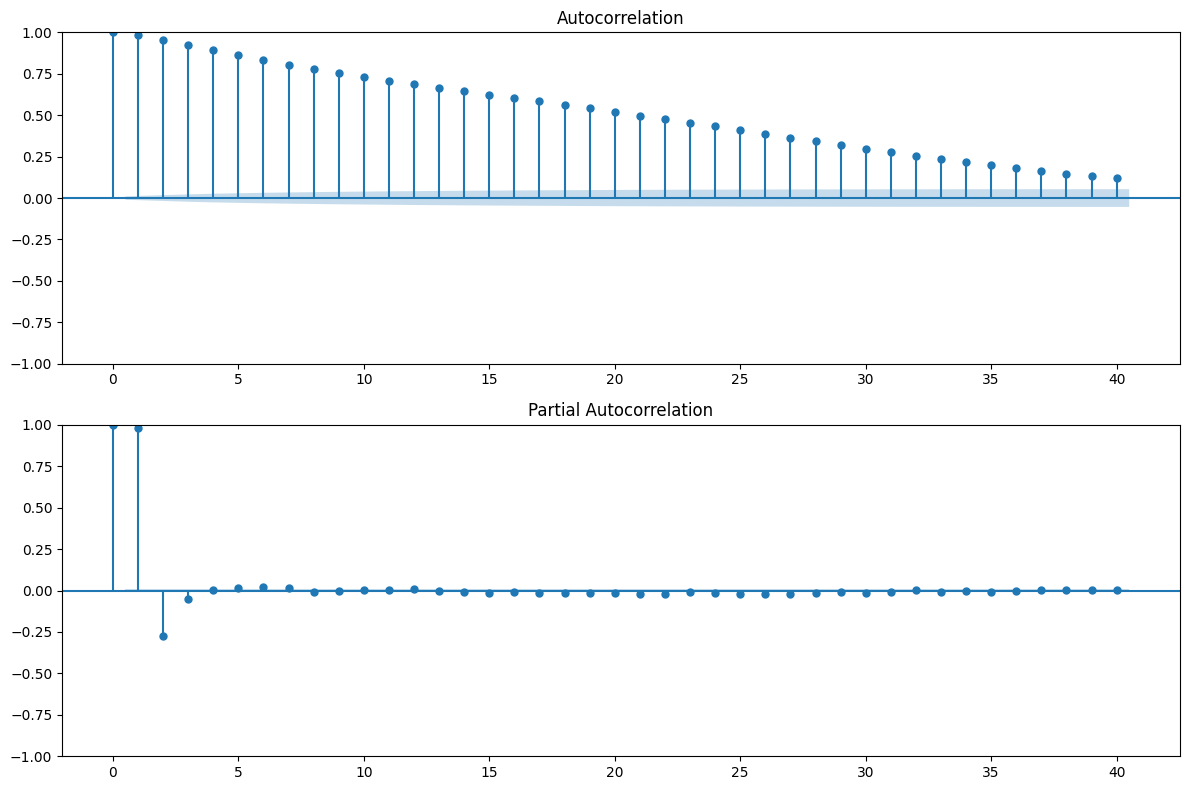

Based on ACF/PACF, recommend checking these parameters:
p (AR order): try values from 1-3
q (MA order): try values from 1-3
Fitting ARIMA(1,1,1) model


/Users/saidhirenmusaloji/Desktop/Dhiren/NJIT/Time Series ML/Project/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/saidhirenmusaloji/Desktop/Dhiren/NJIT/Time Series ML/Project/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/saidhirenmusaloji/Desktop/Dhiren/NJIT/Time Series ML/Project/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 400001   No. Observations:                36481
Model:                 ARIMA(1, 1, 1)   Log Likelihood               94363.449
Date:                Sun, 04 May 2025   AIC                        -188720.898
Time:                        21:14:55   BIC                        -188695.384
Sample:                             0   HQIC                       -188712.787
                              - 36481                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3802      0.009     44.326      0.000       0.363       0.397
ma.L1         -0.1237      0.009    -13.233      0.000      -0.142      -0.105
sigma2         0.0003   7.94e-07    417.897      0.0

/Users/saidhirenmusaloji/Desktop/Dhiren/NJIT/Time Series ML/Project/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/saidhirenmusaloji/Desktop/Dhiren/NJIT/Time Series ML/Project/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


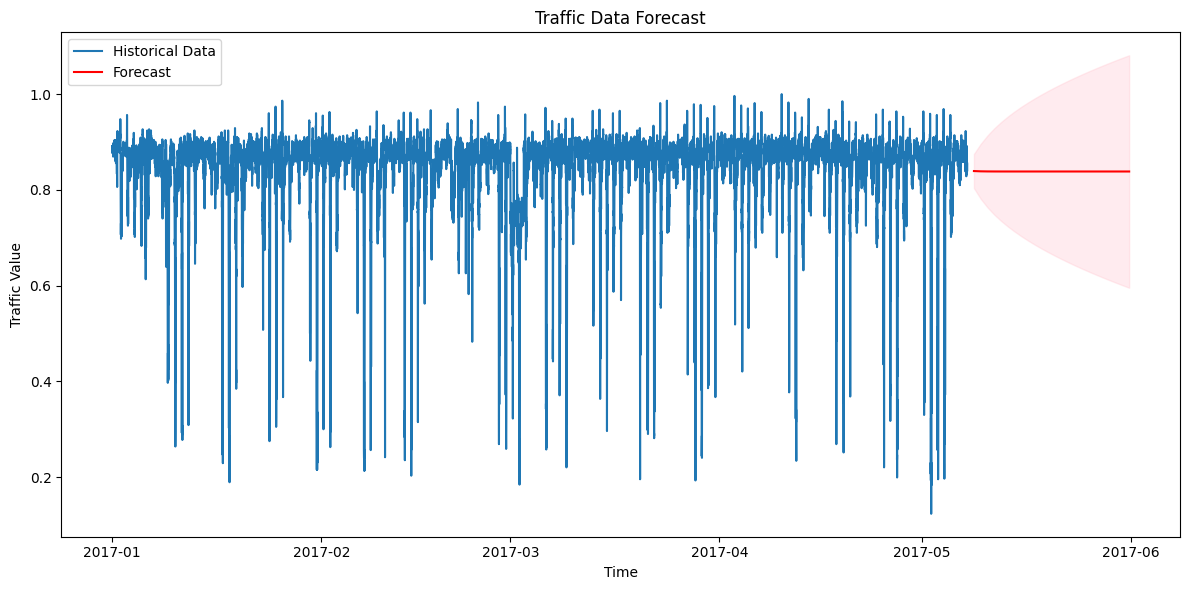


Forecast for next 24 time steps:
36481    0.839277
36482    0.838700
36483    0.838480
36484    0.838397
36485    0.838365
36486    0.838353
36487    0.838348
36488    0.838347
36489    0.838346
36490    0.838346
36491    0.838346
36492    0.838346
36493    0.838346
36494    0.838346
36495    0.838346
36496    0.838346
36497    0.838346
36498    0.838346
36499    0.838346
36500    0.838346
36501    0.838346
36502    0.838346
36503    0.838346
36504    0.838346
Name: predicted_mean, dtype: float64


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 1. Load and prepare data
def load_data(filepath):
    """Load traffic data and set timestamp as index"""
    data = pd.read_csv(filepath)
    
    # Properly handle time index if it exists as a column
    if 'Unnamed: 0' in data.columns:
        # Convert to datetime and set as index
        data['timestamp'] = pd.to_datetime(data['Unnamed: 0'])
        data = data.set_index('timestamp')
        data = data.drop(columns=['Unnamed: 0'])
    
    print(f"Data loaded with shape: {data.shape}")
    return data

# 2. Select a sensor and prepare time series
def prepare_sensor_data(data, sensor_id=None):
    """Extract a single sensor's data for time series analysis"""
    # If no sensor specified, use the first sensor column
    if sensor_id is None:
        # Skip the first column if it's not a sensor
        sensor_id = data.columns[0]
        
    print(f"Selected sensor: {sensor_id}")
    
    # Extract the sensor data
    sensor_data = data[sensor_id]
    
    # Check for non-numeric values
    if not pd.api.types.is_numeric_dtype(sensor_data):
        print(f"Warning: Converting non-numeric values to numeric")
        sensor_data = pd.to_numeric(sensor_data, errors='coerce')
        
    # Handle any NaN values with linear interpolation
    if sensor_data.isna().any():
        print(f"Filling {sensor_data.isna().sum()} NaN values with interpolation")
        sensor_data = sensor_data.interpolate(method='linear').ffill().bfill()
    
    return sensor_data

# 3. Check for stationarity
def check_stationarity(series):
    """Test time series stationarity using ADF test"""
    # Run Augmented Dickey-Fuller test
    result = adfuller(series.dropna())
    
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    
    # Interpret results
    if result[1] <= 0.05:
        print("Series is stationary (reject H0)")
        return True
    else:
        print("Series is not stationary (fail to reject H0)")
        return False

# 4. Differencing if needed
def make_stationary(series, max_diff=2):
    """Apply differencing to make series stationary"""
    diff_series = series.copy()
    d = 0
    
    while d < max_diff:
        if check_stationarity(diff_series):
            print(f"Series stationary after {d} differences")
            return diff_series, d
        
        print(f"Applying differencing (d={d+1})")
        diff_series = diff_series.diff().dropna()
        d += 1
    
    print(f"Warning: Series still not stationary after {max_diff} differences")
    return diff_series, d

# 5. Identify model parameters
def identify_arima_params(series, max_p=3, max_q=3):
    """Plot ACF/PACF to identify ARIMA parameters"""
    plt.figure(figsize=(12, 8))
    
    # ACF plot for MA(q) parameter
    plt.subplot(211)
    plot_acf(series, ax=plt.gca(), lags=40)
    
    # PACF plot for AR(p) parameter
    plt.subplot(212)
    plot_pacf(series, ax=plt.gca(), lags=40)
    
    plt.tight_layout()
    plt.show()
    
    # Suggest parameters based on rule of thumb
    p = 0
    q = 0
    
    print("Based on ACF/PACF, recommend checking these parameters:")
    print("p (AR order): try values from 1-3")
    print("q (MA order): try values from 1-3")
    
    return p, q

# 6. Fit ARIMA model
def fit_arima(series, p, d, q):
    """Fit ARIMA model with specified parameters"""
    print(f"Fitting ARIMA({p},{d},{q}) model")
    
    try:
        model = ARIMA(series, order=(p, d, q))
        results = model.fit()
        print(results.summary())
        return results
    except Exception as e:
        print(f"Error fitting ARIMA model: {str(e)}")
        return None

# 7. Forecast and plot results
def forecast_and_plot(series, model, steps=24):
    """Generate and plot forecast"""
    if model is None:
        print("No model available for forecasting")
        return
    
    # Generate forecast
    forecast = model.get_forecast(steps=steps)
    forecast_index = pd.date_range(series.index[-1], periods=steps+1, freq=series.index.freq)[1:]
    forecast_mean = forecast.predicted_mean
    conf_int = forecast.conf_int()
    
    # Plot original series and forecast
    plt.figure(figsize=(12, 6))
    plt.plot(series.index, series, label='Historical Data')
    plt.plot(forecast_index, forecast_mean, 'r-', label='Forecast')
    plt.fill_between(forecast_index, 
                    conf_int.iloc[:, 0], 
                    conf_int.iloc[:, 1], 
                    color='pink', alpha=0.3)
    
    plt.title('Traffic Data Forecast')
    plt.xlabel('Time')
    plt.ylabel('Traffic Value')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Return forecast
    return forecast_mean, conf_int

# Main execution
if __name__ == "__main__":
    # 1. Load data
    data = load_data("data/processed/train.csv")
    
    # 2. Explore data
    print("\nData sample:")
    print(data.head())
    
    # 3. Select a sensor and prepare time series
    # Choose a specific sensor with more data volume if you know one
    sensor_data = prepare_sensor_data(data)
    
    # 4. Check and ensure stationarity
    stationary_data, d = make_stationary(sensor_data)
    
    # 5. Identify ARIMA parameters
    p, q = identify_arima_params(stationary_data)
    
    # 6. Fit ARIMA model
    # You can adjust these parameters based on ACF/PACF results
    p = 1  # AR order
    d = 1  # Differencing
    q = 1  # MA order
    model = fit_arima(sensor_data, p, d, q)
    
    # 7. Generate forecast
    forecast, conf_int = forecast_and_plot(sensor_data, model, steps=24)
    
    print("\nForecast for next 24 time steps:")
    print(forecast)

Loading data from data/processed/train.csv
Data loaded successfully with shape: (36481, 325)
Columns: Index(['400001', '400017', '400030', '400040', '400045'], dtype='object')...

Analyzing sensor: 400001

Descriptive statistics:
count    36481.000000
mean         0.841161
std          0.100094
min          0.123134
25%          0.839552
50%          0.874378
75%          0.886816
max          1.000000
Name: 400001, dtype: float64
Saved sensor data visualization to sensor_data.png

Fitting ARIMA(1,1,1) model...


/Users/saidhirenmusaloji/Desktop/Dhiren/NJIT/Time Series ML/Project/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/saidhirenmusaloji/Desktop/Dhiren/NJIT/Time Series ML/Project/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/saidhirenmusaloji/Desktop/Dhiren/NJIT/Time Series ML/Project/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



Model summary:
                               SARIMAX Results                                
Dep. Variable:                 400001   No. Observations:                36481
Model:                 ARIMA(1, 1, 1)   Log Likelihood               94363.449
Date:                Sun, 04 May 2025   AIC                        -188720.898
Time:                        21:15:15   BIC                        -188695.384
Sample:                             0   HQIC                       -188712.787
                              - 36481                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3802      0.009     44.326      0.000       0.363       0.397
ma.L1         -0.1237      0.009    -13.233      0.000      -0.142      -0.105
sigma2         0.0003   7.94e-07    

/Users/saidhirenmusaloji/Desktop/Dhiren/NJIT/Time Series ML/Project/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/saidhirenmusaloji/Desktop/Dhiren/NJIT/Time Series ML/Project/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


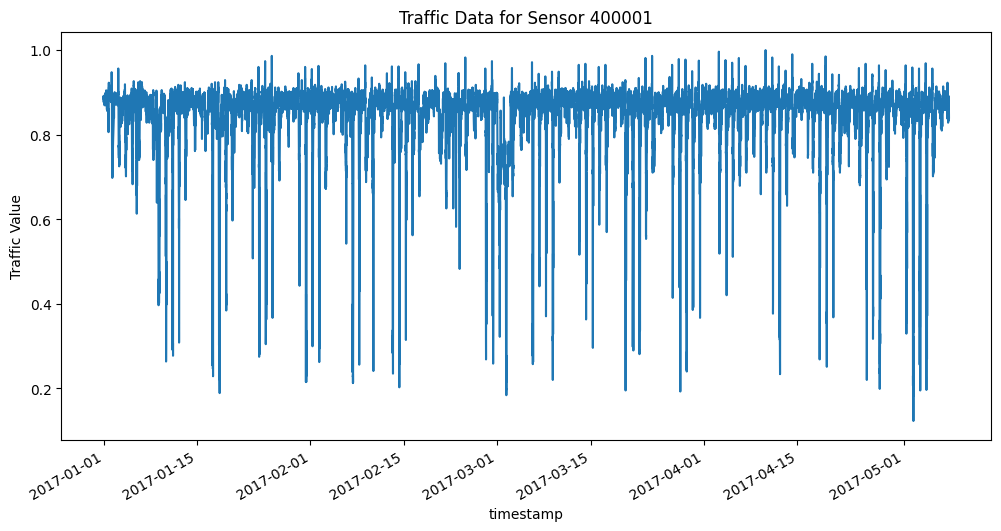

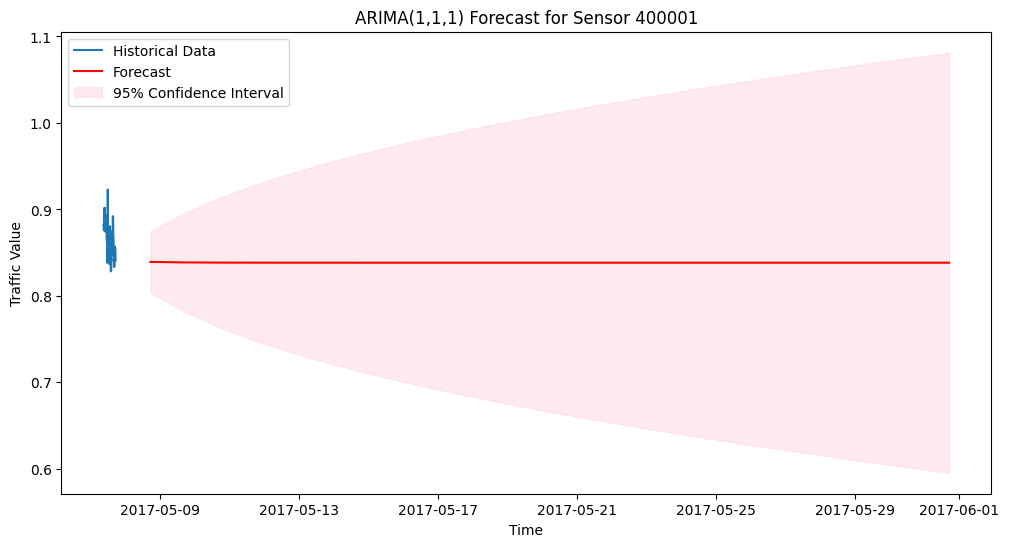

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.arima.model import ARIMA

# Let's create a simpler execution script for your ARIMA model

# 1. Load data - specify the path to your processed CSV file
data_path = "data/processed/train.csv"
print(f"Loading data from {data_path}")

if not os.path.exists(data_path):
    print(f"Error: File not found at {data_path}")
    print("Current directory:", os.getcwd())
    print("Available files:", os.listdir("data/processed/") if os.path.exists("data/processed/") else "data/processed/ directory not found")
else:
    # Load the data
    df = pd.read_csv(data_path)
    
    # Convert the first column to datetime and set as index
    df['timestamp'] = pd.to_datetime(df['Unnamed: 0'])
    df = df.set_index('timestamp')
    df = df.drop(columns=['Unnamed: 0'])
    
    print(f"Data loaded successfully with shape: {df.shape}")
    print(f"Columns: {df.columns[:5]}...")  # Show first 5 column names
    
    # 2. Select a specific sensor for analysis
    # Let's choose the first sensor column for simplicity
    sensor_id = df.columns[0]
    print(f"\nAnalyzing sensor: {sensor_id}")
    
    # Extract the sensor data
    sensor_data = df[sensor_id].copy()
    
    # Quick data check
    print("\nDescriptive statistics:")
    print(sensor_data.describe())
    
    # 3. Visualize the sensor data
    plt.figure(figsize=(12, 6))
    sensor_data.plot()
    plt.title(f'Traffic Data for Sensor {sensor_id}')
    plt.ylabel('Traffic Value')
    plt.savefig('sensor_data.png')
    print("Saved sensor data visualization to sensor_data.png")
    
    # 4. Fit ARIMA model
    # Use simple parameters to start
    p, d, q = 1, 1, 1  # Simple ARIMA(1,1,1) model
    
    print(f"\nFitting ARIMA({p},{d},{q}) model...")
    try:
        model = ARIMA(sensor_data, order=(p, d, q))
        results = model.fit()
        
        print("\nModel summary:")
        print(results.summary().tables[0].as_text())
        print(results.summary().tables[1].as_text())
        
        # 5. Generate forecast
        steps = 24  # 24 steps ahead forecast
        forecast = results.get_forecast(steps=steps)
        forecast_mean = forecast.predicted_mean
        conf_int = forecast.conf_int()
        
        # Create forecast index (continuing from the last data point)
        forecast_index = pd.date_range(start=sensor_data.index[-1], 
                                      periods=steps+1, freq=pd.infer_freq(sensor_data.index))[1:]
        
        # 6. Plot results
        plt.figure(figsize=(12, 6))
        plt.plot(sensor_data.index[-100:], sensor_data.iloc[-100:], label='Historical Data')
        plt.plot(forecast_index, forecast_mean, 'r-', label='Forecast')
        plt.fill_between(forecast_index, 
                        conf_int.iloc[:, 0], 
                        conf_int.iloc[:, 1], 
                        color='pink', alpha=0.3, label='95% Confidence Interval')
        
        plt.title(f'ARIMA({p},{d},{q}) Forecast for Sensor {sensor_id}')
        plt.xlabel('Time')
        plt.ylabel('Traffic Value')
        plt.legend()
        plt.savefig('arima_forecast.png')
        print("Saved forecast visualization to arima_forecast.png")
        
        # 7. Print forecast values
        print("\nForecast for next 24 time steps:")
        print(forecast_mean)
        
    except Exception as e:
        print(f"Error fitting ARIMA model: {str(e)}")
        
        # Show useful diagnostics
        print("\nData diagnostics:")
        print(f"Any NaN values: {sensor_data.isna().any()}")
        print(f"Number of NaN values: {sensor_data.isna().sum()}")
        print(f"Data type: {sensor_data.dtype}")
        
        # Try with interpolated data if there are issues
        print("\nAttempting with cleaned data...")
        sensor_data = sensor_data.interpolate().ffill().bfill()
        
        try:
            model = ARIMA(sensor_data, order=(p, d, q))
            results = model.fit()
            print("Model successfully fit after cleaning data!")
        except Exception as e2:
            print(f"Still failed: {str(e2)}")

Loading datasets...
Selected sensor: 400001


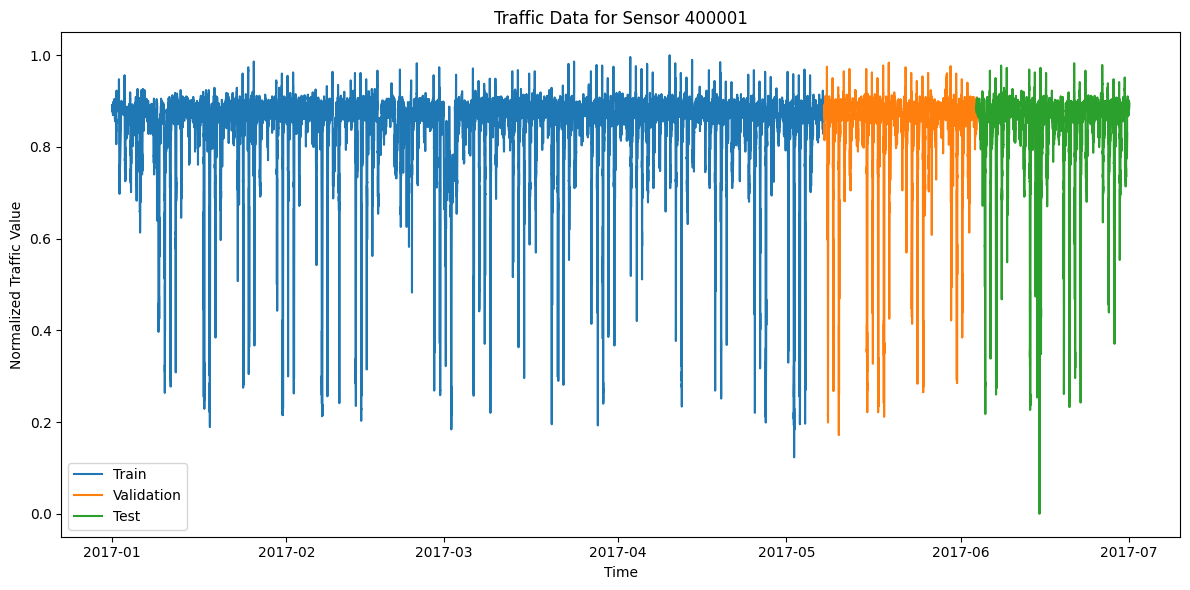

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# 1. Load the pre-processed datasets
print("Loading datasets...")
train_df = pd.read_csv("data/processed/train.csv", index_col=0, parse_dates=True)
val_df = pd.read_csv("data/processed/val.csv", index_col=0, parse_dates=True)
test_df = pd.read_csv("data/processed/test.csv", index_col=0, parse_dates=True)

# 2. Select a single sensor for ARIMA modeling (we'll use the first one)
sensor_id = train_df.columns[0]
print(f"Selected sensor: {sensor_id}")

# Extract time series for the selected sensor
train_series = train_df[sensor_id]
val_series = val_df[sensor_id]
test_series = test_df[sensor_id]

# 3. Basic visualization
plt.figure(figsize=(12, 6))
plt.plot(train_series, label='Train')
plt.plot(val_series, label='Validation')
plt.plot(test_series, label='Test')
plt.title(f'Traffic Data for Sensor {sensor_id}')
plt.xlabel('Time')
plt.ylabel('Normalized Traffic Value')
plt.legend()
plt.tight_layout()
plt.savefig('traffic_timeseries.png')
plt.show()
plt.close()

# Uncomment to run multivariate analysis
# print("\nBuilding ARIMA models for multiple sensors...")
# multi_results = build_multivariate_arima(train_df, val_df, test_df, top_n=3)

In [58]:

# 4. Check stationarity with Augmented Dickey-Fuller test
def check_stationarity(series):
    """Check if time series is stationary using ADF test"""
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    is_stationary = result[1] < 0.05
    print(f'Is Stationary: {is_stationary}')
    return is_stationary

print("\nChecking stationarity...")
is_stationary = check_stationarity(train_series)


Checking stationarity...
ADF Statistic: -24.8248
p-value: 0.0000
Is Stationary: True


In [59]:

# 5. If not stationary, difference the series (simple way to make stationary)
diff_order = 0
train_stationary = train_series.copy()

if not is_stationary:
    print("Series is not stationary. Applying differencing...")
    train_stationary = train_series.diff().dropna()
    diff_order = 1
    is_stationary = check_stationarity(train_stationary)
    
    # Try second differencing if still not stationary
    if not is_stationary:
        print("Applying second differencing...")
        train_stationary = train_stationary.diff().dropna()
        diff_order = 2
        is_stationary = check_stationarity(train_stationary)

In [60]:

# 6. Grid search for best ARIMA parameters
def evaluate_arima(p, d, q, train, test):
    """Fit ARIMA model and evaluate on test data"""
    try:
        model = ARIMA(train, order=(p, d, q))
        model_fit = model.fit()
        
        # Make forecasts
        forecast = model_fit.forecast(steps=len(test))
        
        # Calculate error metrics
        mse = mean_squared_error(test, forecast)
        mae = mean_absolute_error(test, forecast)
        return mse, mae, model_fit
    except:
        return float('inf'), float('inf'), None

print("\nPerforming ARIMA grid search...")
best_mse = float('inf')
best_params = None
best_model = None

# Grid search parameters (simplified to speed up execution)
p_values = range(0, 3)
q_values = range(0, 3)
d = diff_order  # Use the differencing determined earlier

for p in p_values:
    for q in q_values:
        mse, mae, model = evaluate_arima(p, d, q, train_series, val_series)
        if mse < best_mse:
            best_mse = mse
            best_params = (p, d, q)
            best_model = model
            print(f"New best ARIMA{best_params}: MSE={best_mse:.6f}, MAE={mae:.6f}")


Performing ARIMA grid search...
New best ARIMA(0, 0, 0): MSE=0.011408, MAE=0.061205
New best ARIMA(0, 0, 2): MSE=0.011408, MAE=0.061206


In [61]:

# 7. Train final model with best parameters
print(f"\nTraining final ARIMA{best_params} model...")
final_model = ARIMA(pd.concat([train_series, val_series]), order=best_params)
final_model_fit = final_model.fit()

# 8. Generate forecasts for test set
forecast_steps = len(test_series)
forecasts = final_model_fit.forecast(steps=forecast_steps)

# 9. Evaluate on test set
test_mse = mean_squared_error(test_series, forecasts)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(test_series, forecasts)

print(f"\nTest set evaluation:")
print(f"MSE: {test_mse:.6f}")
print(f"RMSE: {test_rmse:.6f}")
print(f"MAE: {test_mae:.6f}")


Training final ARIMA(0, 0, 2) model...

Test set evaluation:
MSE: 0.009825
RMSE: 0.099123
MAE: 0.059354


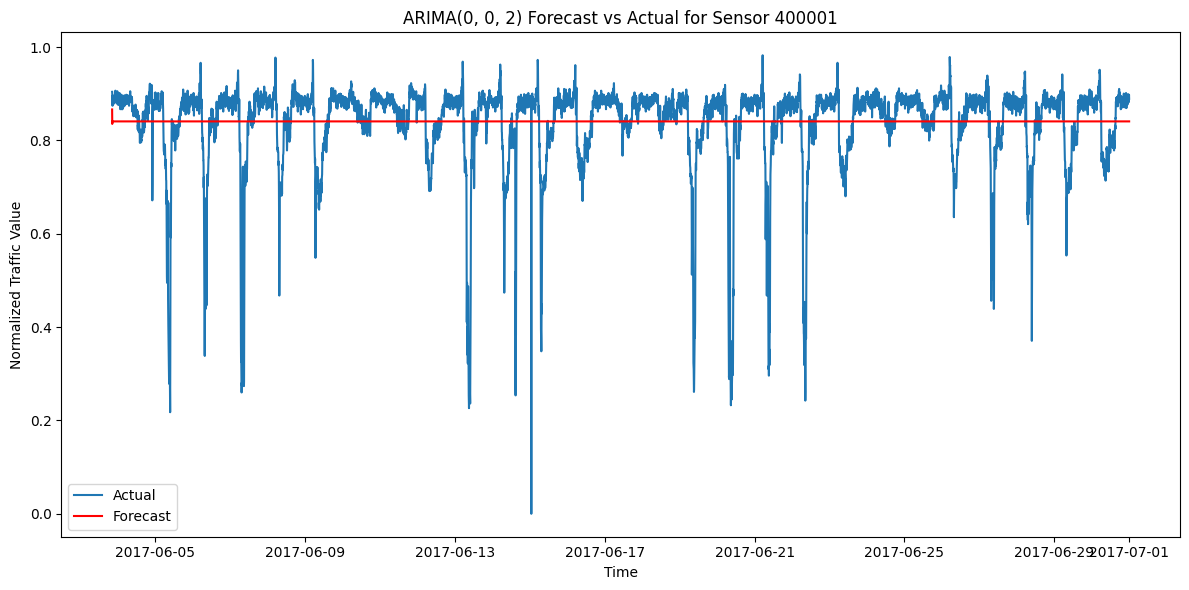


Model Summary:
                               SARIMAX Results                                
Dep. Variable:                 400001   No. Observations:                44298
Model:                 ARIMA(0, 0, 2)   Log Likelihood               81793.338
Date:                Sun, 04 May 2025   AIC                        -163578.676
Time:                        21:24:39   BIC                        -163543.881
Sample:                             0   HQIC                       -163567.715
                              - 44298                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8409      0.001    962.601      0.000       0.839       0.843
ma.L1          1.3526      0.002    711.760      0.000       1.349       1.356
ma.L2          0.7397      0.002    

In [62]:

# 10. Plot results
plt.figure(figsize=(12, 6))
plt.plot(test_series.index, test_series, label='Actual')
plt.plot(test_series.index, forecasts, label='Forecast', color='red')
plt.title(f'ARIMA{best_params} Forecast vs Actual for Sensor {sensor_id}')
plt.xlabel('Time')
plt.ylabel('Normalized Traffic Value')
plt.legend()
plt.tight_layout()
plt.savefig('arima_forecast.png')
plt.show()

# 11. Model diagnostics
print("\nModel Summary:")
print(final_model_fit.summary())

In [63]:


# 12. Multi-step forecast
print("\nGenerating 24-step forecast beyond test data...")
future_forecast = final_model_fit.forecast(steps=24)
print(future_forecast)

# 13. Advanced: Build ARIMA models for multiple sensors
def build_multivariate_arima(train_df, val_df, test_df, top_n=5):
    """Build ARIMA models for multiple sensors"""
    results = {}
    
    # Only use top_n sensors to speed up execution
    sensors = train_df.columns[:top_n]
    
    for sensor in sensors:
        print(f"\nProcessing sensor: {sensor}")
        train_series = train_df[sensor]
        val_series = val_df[sensor]
        test_series = test_df[sensor]
        
        # Find best model
        best_mse = float('inf')
        best_params = None
        
        for p in range(0, 2):  # Simplified grid search
            for q in range(0, 2):
                mse, mae, model = evaluate_arima(p, 0, q, train_series, val_series)
                if mse < best_mse:
                    best_mse = mse
                    best_params = (p, 0, q)
        
        # Train final model
        final_model = ARIMA(pd.concat([train_series, val_series]), order=best_params)
        final_model_fit = final_model.fit()
        
        # Generate forecasts
        forecasts = final_model_fit.forecast(steps=len(test_series))
        
        # Calculate metrics
        test_mse = mean_squared_error(test_series, forecasts)
        test_rmse = np.sqrt(test_mse)
        
        results[sensor] = {
            'params': best_params,
            'mse': test_mse,
            'rmse': test_rmse
        }
        
        print(f"  Best model: ARIMA{best_params}, RMSE: {test_rmse:.6f}")
    
    return results



Generating 24-step forecast beyond test data...
44298    0.866452
44299    0.835452
44300    0.840860
44301    0.840860
44302    0.840860
44303    0.840860
44304    0.840860
44305    0.840860
44306    0.840860
44307    0.840860
44308    0.840860
44309    0.840860
44310    0.840860
44311    0.840860
44312    0.840860
44313    0.840860
44314    0.840860
44315    0.840860
44316    0.840860
44317    0.840860
44318    0.840860
44319    0.840860
44320    0.840860
44321    0.840860
Name: predicted_mean, dtype: float64


In [57]:
print("\nBuilding ARIMA models for multiple sensors...")
multi_results = build_multivariate_arima(train_df, val_df, test_df, top_n=3)


Building ARIMA models for multiple sensors...

Processing sensor: 400001
  Best model: ARIMA(0, 0, 0), RMSE: 0.099124

Processing sensor: 400017
  Best model: ARIMA(1, 0, 1), RMSE: 0.225825

Processing sensor: 400030
  Best model: ARIMA(1, 0, 0), RMSE: 0.147434
